In [1]:
%run Latex_macros.ipynb

<IPython.core.display.Latex object>

Macro `_latex_std_` created. To execute, type its name (without quotes).
=== Macro contents: ===
get_ipython().run_line_magic('run', 'Latex_macros.ipynb')
 

$
\newcommand{\tx}{\tilde{\x}}
$

In [2]:
# My standard magic !  You will see this in almost all my notebooks.

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

# Reload all modules imported with %aimport
%load_ext autoreload
%autoreload 1

%matplotlib inline

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA

import os 

import seaborn as sns; sns.set()

import unsupervised_helper
%aimport unsupervised_helper

vp = unsupervised_helper.VanderPlas()


# Unsupervised Learning

- No targets
- Why use it ?
    - Understand your features
    - Better use of features in supervised models

# Plan
- Principal Components
    - Highly popular model for dimensionality reduction
- Clustering
    - K-means to cluster samples
    - Hierarchical clustering
- Recommender systems
    - Netflix prize
    - Pseudo SVD

# What is PCA

- a way to reduce dimensionality of features
    - Do we really need all 784 pixels in MNIST ?
    - Hedging in Fixed Income
- a way to cluster samples based on similarity of *features*
- contrast this to Decision Tree
    - also clusters samples with similar features
    - but guided by the clusters having same targets




# PCA: High Level

<div class="alert alert-block alert-warning">
    <b>TL;DR</b> 
    <br>
    <ul>
        <li>PCA is a technique for creating "synthetic features" from the original set of features</li>
        <li>The synthetic features may better reveal relationships among original features</li>
        <li>May be able to use reduced set of synthetic features (dimensionality reduction)</li>
        <li>Synthetic features as a means of clustering samples</li>
        <li>All features need (and will be assumed to be) centered: zero mean</li>
        <li>PCA is very scale sensitive; often normalize each feature to put on same scale</li>
        </div>


The key ideas behind PCA:
- Dimension reduction: from $n$ "original" features to $n' \le n$ "synthetic" features
    - synthetic features are more like "concepts" than attributes
    - commonality of purpose
- Feature transformation: from correlated original features to *independent* synthetic features
- Order of "importance" of synthetic features
    - Drop the less important synthetic features: dimension reduction
    - Important relative to feature variation *not* prediction
        - unlike Decision Trees; there is no target

**Preview**

In one picture:

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


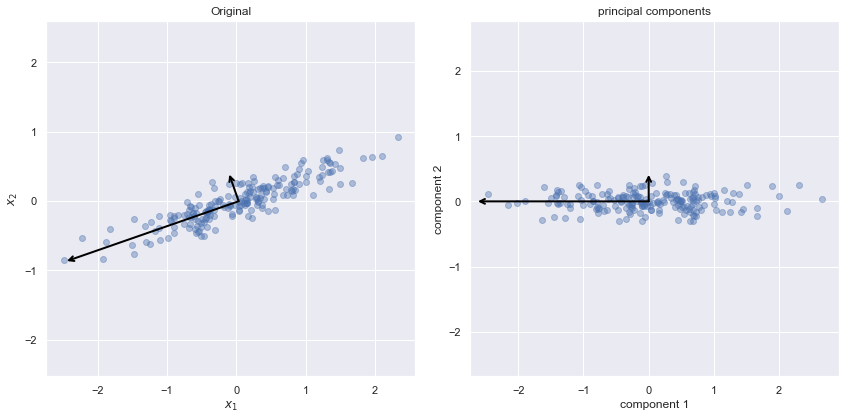

In [4]:
X = vp.create_data()
vp.show_2D(X)

- The same examples
- Transformation of features
    - from correlated original features $\x_1, \x_2$ 
    - to synthetic features $\tx_1, \tx_2$
    - $\tx_1, \tx_2$
        - are *independent*
        - are *ordered*

# Notation
$\X = \{ \x^\ip \; | \,  i = 1, \ldots, m \}$

No targets !

Feature $j$ is the variable

$
\x_j = [ \x^\ip_j  \; |  \; i = 1, \ldots, m ]
$
- order is important
    - preserve correlation across $\x_j, \x_{j'}$

## Dimension Reduction: motivation


### Dimension reduction: examples

**Color 3D movie to Black/white still image example**
- Lose Depth
- Lose color of eyes/hair/clothing
- Lose motion
    - but pose may be informative

For the purpose of recognizing a person, little information is lost
            

**MNIST digit example**

- $n=784: (28 \times 28)$ grid
- the 4 corners are almost always black
    - not informative for classification
    - **redundant** since all the black pixels are the same
    
Can probably get away with $n' \lt n$ pixels without losing the ability to distinguish between digits.


## Clustering: motivation

By reducing to 2,3 synthetic features and plotting:
- clusters of examples appear, when the clutter of "less important" features are removed
- clusters are of examples with *similar features*: there are no targets
- contrast this to Decision Tree
    - also clusters samples with similar features
    - but guided by the clusters having same targets


## From correlated original to independent synthetic features

Example of correlated features
- [VanderPlas notebook](external/PythonDataScienceHandbook/notebooks/05.09-Principal-Component-Analysis.ipynb)

- Examples: workers within a single profession, with features including Age, Wage
    - Age and Wage appear to be correlated
    
"Correlation doesn't imply causation" but sometimes:
- correlated variables are different manifestations of a common concept ("factor")
- Age and Wage both related to Years of Experience
    - Years of Experience is common factor that explains why Age and Wage move together

Let's create two correlated features and plot them.

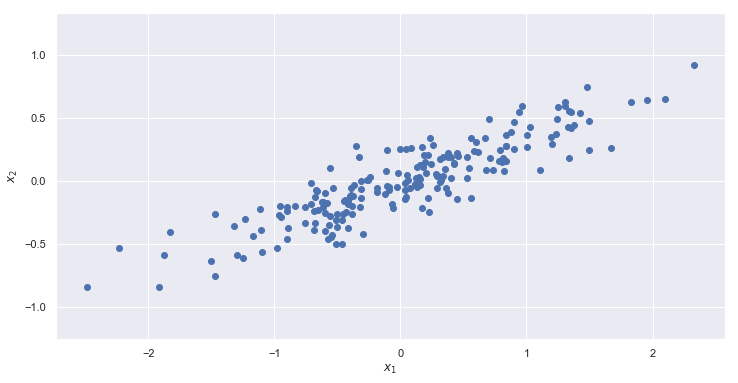

In [5]:
fig, ax = plt.subplots(1,1, figsize=(12,6))
_= ax.scatter(X[:, 0], X[:, 1])
_= ax.axis('equal');
_= ax.set_xlabel("$x_1$")
_= ax.set_ylabel("$x_2$")


### 2D example: feature correlation in terms of mutual relationship to common factor

An intuitive way to understand the correlation of features $\x_1$ and $\x_2$
- assume the existence of a factor common to both ("concept")
- re-express $\x_1, \x_2$ in terms of their common factor

**Examples**
- Stocks: feature $j$ is return (one day) of stock $j$, for $j = 1, \dots, n$
    - $\x^\ip_j$ is return of stock $j$ on day $i$
    - the variables (length $m$) $\x_j, \x_{j'}$ correlated
    - through common exposure of all stocks to market factor
- wages correlated with age (within a profession)
    - common factor: years of experience

We show how the decomposition of $\x_j, j=1,2$ into a common factor works.

Let 
- $c$ denote the hypothesized factor common to $\x_1$ and $\x_2$
- $z_j, j=1,2$
    - are standard unit normal variables
        - $E(z_j) = 0, E(z_j^2) = \sigma_{z_i}^2 = 1$
    - *independent* of $c$ and one another:
        - $E( c * z_j ) = 0, E( z_1 * z_2 ) = 0$

Re-write $\x_1, \x_2$:
$$
\begin{array}[lll]\\
\x_1 = \rho_1 * (\sigma_{\x_1}/\sigma_{c}) * c + \sqrt{1 - \rho_1^2} * \sigma_{\x_1} * z_1 \\
\x_2 = \rho_2 * (\sigma_{\x_2}/\sigma_{c}) * c + \sqrt{1 - \rho_2^2} * \sigma_{\x_2} * z_2
\end{array}
$$
where
- $\sigma_{\x_j}$ is the standard deviation of $\x_j, i=1,2$
- $\rho_j$ is the correlation of $c$ with $\x_i, j=1,2$

So $\x_1, \x_2$ have common factor $c$ that cause them to move somewhat together.
- and move independently through $z_1, z_2$

Let's verify that the variance of the right hand side is the variance of $\x_i, i=1$
$$
\begin{array}{lll}
E(\x_1^2) & = & \rho_1^2 (\sigma_{\x_1}^2/\sigma_c^2)*E(c^2) + (1 - \rho_1^2) \sigma_{\x_1}^2 * E(z_1^2)  & \text{ since } E(c, \z_i) = 0 \\
\sigma_1^2 & = & \sigma_{\x_1}^2 ( \rho_1^2 + (1 -\rho_1^2)) & \text{since } E(\x_i^2) = \sigma_{\x_i}^2, E(c^2) = \sigma_c^2, E(z_i^2) = 1 \\
\sigma_1^2 & = & \sigma_1^2 \\
\end{array}
$$

The total variance of $\x_1$ has been partitioned
- variance due to common factor $c: \rho_1^2 \sigma_{\x_1}^2$
- variance independent of $c: (1 - \rho_1^2) \sigma_{\x_1}^2$:

Does the term $\rho_j * (\sigma_{\x_j}/\sigma_{c})$ which weights $\x_j$ on common factor $c$ have a meaning ?

Yes !
- it is the coefficient $\Theta_{1,i}$ of the regression $\x_i = \theta_{1,i} * c + \epsilon$
- the terms $\sqrt{1 - \rho_1^2} * \sigma_{\x_j} * z_1$ serves the role of $\epsilon$
    - it is independent of $\x_j$

So our equations
- are regressing original features onto a single common factor
- finding the part of the original feature that is *independent* of the common factor

PCA will create synthetic features $\tx_1, \ldots, \tx_n$ that capture the commonality of the original.

- Takes design matrix $\X$ with original features $\x_1, \ldots, \x_n$

- Creates design matrix $\tilde{\X}$ with synthetic features $\tx_1, \ldots, \tx_n$

Each feature $\x_i$ can be expressed as a linear combo of synthetic features $\tilde{\x}_j$

$$\x_j = \sum_{k=1}^n { \beta_{j,k} * \tx_k }$$

where $\beta_{j,k}$ is the "weight" for $\x_j$ on $\tx_k$.

We will also see that synthetic features $\tx_j$ are constructed as combinations of original features

$$\tx_j = \sum_{k=1}^n { \tilde{\beta}_{j,k} * \x_k }$$

where $\tilde\beta_{i,j}$ is the "weight" for $\tx_i$ on $\x_j$.

Bottom line:
- we can map original features to linear combinations of synthetic features
- we can map synthetic features to linear combinations of original features

### PCA as a rotation

We can define an $(n \times n)$ matrix $W$ that maps $\X$ to $\tilde\X$:

$\tilde{\X} = \X \W$

- Transformed $\tilde{\X}$ is a rotation of $\X$ defined by $\W$
- Column $j$ of  $\tilde{\X}$ is $\tx_j$

The transformation $\W$ constructed by PCA has the properties

- $\tx_j, \tx_{j'}$ uncorrelated for $j \ne j'$
    - this means covariance matrix of $\tilde\X$  is diagonal (off-diagonal all zero)
- The standard deviations of the synthetic features is ordered:
    - $\sigma_{\tx_j} > \sigma_{\tx_{j'}}, \text{ for } j < j'$
    

We can hopefully gain some intuition on constructing $\W$ via an example where $n=2$.

In light of our re-writing $\x$ in the form of a regression against $c$ we can
- find $\tx_1$ via a regression ($c$ becomes $\tx_1$)
- compute the residuals of the regression
- update $\x$ to the residuals
- repeat the process to find $\tx_2$

If $n > 2$ this process would have $n$ steps.

The first regression results in
- a rotation of $\x$
- such that
    - the line of best fit becomes the new horizontal axis ($\tx_1$)
    - the spread (min to max) of values along the new horizontal axis is maximized among all rotations
    
The residuals of $\x$ from this regression are *uncorrelated* with $c = \tx_1$
- so the $\tx_2$ constructed in the next step will be *uncorrelated* with $\tx_1$

   

**Notes**
- the line of best fit minimizes the residuals (by definition of the MSE loss function)
    - so the distance to $\x$ measured orthogonal to $\tx_1$ is minimized (definition of residual)
- among all the rotations, we choose the one that maximizes the spread along the new $\tx_1$
    - This will ensure that $\sigma_{\tx_j} > \sigma_{\tx_{j'}}$

A picture will help

[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


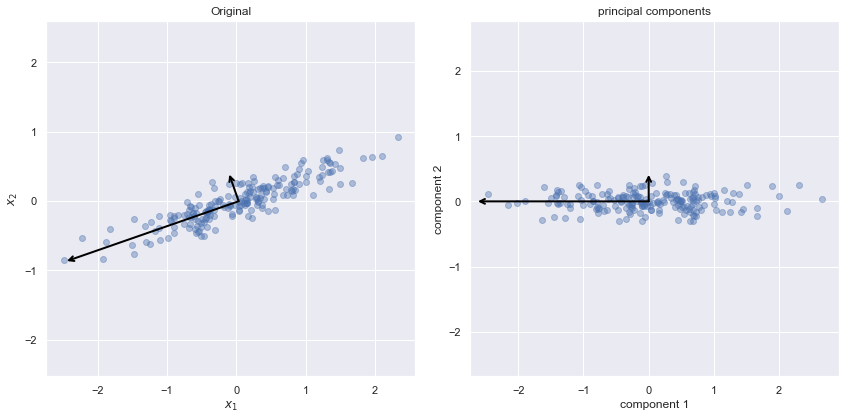

In [6]:
vp.show_2D(X)

- The scatter plot is $\x_1$ versus $\x_2$
- the solid, long line is the line of best fit $\x_2 = \theta \x_1$
- the short, solid line is in the direction of residuals and is $\tx_2$
- the figure on the right just rotates the picture on the left to make $\tx_1$ horizontal
    - plots $\tx_2$ versus $\tx_1$

## The plan

In practice, we don't carry out this multi-step process of regession, residual contsruction, etc.

There are *Matrix Factorization* methods that "factor" matrix $\X$ into the transformed $\tilde\X$.

- Matrix factorization:
    - Create $n' = n$ synthetic features
    - but independent
- Ordering features
    - dimension reduction $(n' \lt n)$ by dropping less important synthetic features

# PCA via Matrix factorization

The Matrix Factorization of $\X$ rewrites $\X$ as a product of other matrices.

These other matrices will be used to define the PCAs.

We will show two such factorizations of $\X$ and how the PCAs can be obtained from each.


## Singular Value Decomposition (SVD) Factorization

Factor matrix $X$ into product of 3 matrices:
$$
\X = U \Sigma V^T
$$
- U: $m \times n$, columns are orthogonal unit vectors
    - $U U^T = I$
- $\Sigma: n \times n$ diagonal matrix with diagonal elements $\sigma_1, \ldots, \sigma_n$

- $V: n \times n$, columns are orthogonal unit vectors
    - $V V^T = I$
    
Moreover, the diagonal elements of $\Sigma$ are in descending order of magnitude
$
\sigma_i > \sigma_j
$ for $i < j$

The $W$ that maps $\X$ (examples with original feature) to $\tilde\X$ is defined by

$$W = V$$

as can be seen:
$$
\begin{array}{lll}
\tilde\X & = & \X W \\
& = & \X V  & \text{ since } W = V\\
  & = & (U \Sigma V^T) V  & \text{since } \X = U \Sigma V^T\\
  & = & U \Sigma & \text{since } V^T V = I
\end{array}
$$

$U$ is orthonormal so the synthetic features (columns of $\tilde\X$) are independent,
as required by PCA.

$V$ maps samples from original features to synthetic features.

The expression $\tilde\X = U \Sigma $ is interesting
- $\Sigma$ is the size of a standard deviation in each synthetic feature
    - $\Sigma$ is diagonal with increasing values as column (and row) index $j$ increases
    - The $j^{th}$ diagonal element is the "strength" of synthetic feature $\tx_j$
- $U$ is a "standardized" version of $\tilde\X$: measured in units of standard deviations
    - i.e., the "normal" part of "orthonormal"


Here are scatter plots of our examples
- First with original features
- Second with synthetic features
    - It is $U$, rather than $\tilde\X$
        - that's why the proportions are changed
        - if you multiply by $\Sigma$ you will get the rotated scatter plot of the earlier slide


[[-0.94446029 -0.32862557]
 [-0.32862557  0.94446029]]
[0.7625315 0.0184779]


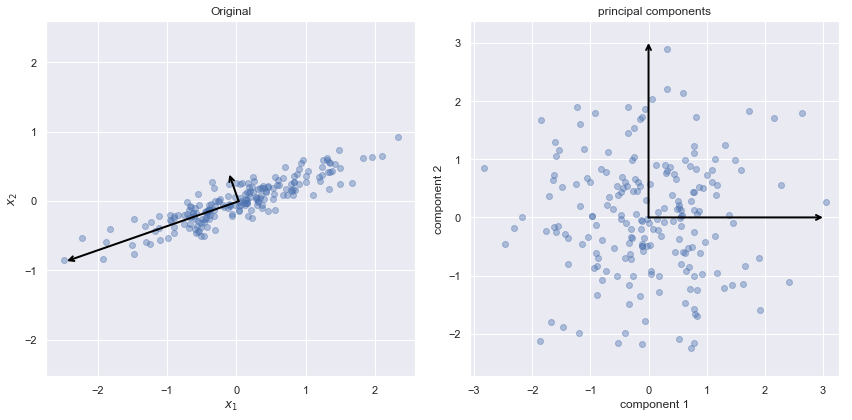

In [7]:
vp.show_2D(X, whiten=True)

## Eigen decomposition of covariance matrix of $X$

There is another matrix factorization method known as Eigen Decomposition.

Eigen decompostion, unlike SVD,  only works on symmetric matrices $M$:

$$
M = W \Lambda W^T
$$

where $W W^T = I$

We can obtain the PCA from the Eigen Decomposition  of $\X \X^T$
- the covariance matrix of $\X$ (i.e., original feature covariance)
- the covariance matrix is symmetric, as required


We can relate the SVD of $\X$ to the Eigen decomposition of $\X \X^T$ as follows:

$$
\begin{array}{lll}
\X^T \X & = &  V \Sigma U^TU \Sigma V^T  & \text{from SVD } \X  =  U \Sigma V^T \\
\X^T \X & = &  V \Sigma \Sigma^T V^T & \text{since } U^T U = I \\
\end{array}
$$

Similarly, we can show

$$
\X \X^T = U \Sigma \Sigma^T U^T \text{since } V V^T = I
$$

Setting
- $\Lambda = \Sigma \Sigma^T$
- $W = U = V$
we get $\X = W \Lambda W^T$, the Eigen Decomposition of $\X \X^T$.

The $V$ that transforms $\X$ (original features)
to $\tilde\X = X V$ (synthetic features) 
- Can be computed directly from SVD
- Or by creating covariance matrix $\X \X^T$ and using Eigen decomposition.

SVD is more commonly used
- There are many fast implementations of SVD
- There is no need to compute the big covariance matrix $\X \X^T$


## Other factorization methods

- CUR method
$$\textrm{CUR}(A) =  C \cdot U \cdot R$$ 
- $C$ chosen from Columns of $R$
- $R$ chosen from Rows of $A$

# Dimensionality reduction

So far, all we have done is 
- exactly reproduce $\X$ by factoring it into other matrices
- re-express $\X$ from original features to synthetic features

A simple extension  will allow us to create "approximations" of $\X$, using
fewer than $n$ synthetic features

Let's define what is means for $\X'$ to be an approximation of $\X$

$$
{|| \X' - \X ||}_2 =  \sum\limits_{i,j}{ \left( {\X'}_{i,j} - \X_{i,j}\right)^2 }
$$

The above is called the Froebenius Norm (and looks like MSE in form).

The "best" approximation $\X'$ of $\X$ is the one with the smallest norm.

## Best lower rank approximation of $\X$

Let 

$$\X = U \Sigma V^T$$

be the SVD of $\X$
where 

- $\Sigma$ is dimension $(n \times n)$ with diagonal element $\sigma_1, \ldots, \sigma_n$ such that

- $
\sigma_i > \sigma_j
$ for $i < j$

$\X_{\text{d-proj}}$ is the best rank $d$ approximation of $\X$, i.e,

$$\X_{\text{d-proj}} = \textrm{argmin}_B { || \X - B ||_2 }$$

when

$$\X_{\text{d-proj}} = U S V^T$$

where

$S$ is the $(n \times n)$ diagonal matrix with
- first $d$ diagonal elements $\sigma_1, \ldots, \sigma_d$
- remaining $(n -d)$ diagonal elements set to $0$

$S$ is a "truncated" version of the $\Sigma$ from SVD (setting diagonal members to $0$ for $j > d$)

The zero elements of $S$ render the last $(n-d)$ columns of $U$ and rows of $V^T$ irrelevant.

$\X_{\text{d-proj}} = U_{\text{d-proj}} \Sigma_{\text{d-proj}} V^T_{\text{d-proj}}$

In words, this effectively reduces the dimensions of $U, \Sigma, V^T$:
- $U_{\text{d-proj}}$ to dimension $(m, d)$
- $\Sigma_{\text{d-proj}}$ to $(d,d)$
- $V^T_{\text{d-proj}}$ to $(d, n)$


In effect, we retain only the first $d$ synthetic features.

So we have reduced the dimension of $\X$ from $n$ features to $\tilde\X$ with  $d$ synthetic features.

### Why dropping low significance synthetic features is low error

Let's examine the reconstruction of $\X$ from $U \Sigma V^T$

Let's  $T_{i,j}$ denote the element at row $i$, column $j$ of $T = V^T$

$\Sigma V^T$ scales the rows of $V^T$ by the diagonal elements.

Let $Z_{i,j}$ denote row $i$, column $j$ of $Z = \Sigma V^T$.

$Z_{i,j} = \sigma_i * T_{i,j}$

Let $U_{i,j}$ denote th element at row $i$, column $j$ of $U$.

Finally $\X_{i,j}$ is the dot product of row $i$ of $U$ and column $j$ of $Z = \Sigma V^T$ 

$$
\begin{array}{lll}
\X_{i,j} & = & U^{(i)} \cdot Z_j \\
         & = & \sum_k { U_{i,k} * Z_{k,j} } \\
         & = & \sum_k { U_{i,k} * T_{k,j} * \sigma_k }
\end{array}
$$

The projection onto $d$ synthetic features drops all terms in the final line where $k > d$.

- So the reconstruction error for $\X_{i,j}$ is
$
\sum_{k >d} { U_{i,k} * T_{k,j} * \sigma_k }
$
- But the diagonal elements of $\Sigma$ are ordered $\sigma_1 \gt  \sigma_2 \gt \ldots \gt \sigma_n$

- So we are dropping $(m-d)$ small magnitude terms 
- If the $(m-d)$ smallest elements of $\Sigma$
    $$(\sigma_{n -m + d+1}, \ldots, \sigma_n)$$
    are close to $0$
the error is minimized.

That's why we drop higher order synthetic features rather than lower order.

## How many dimensions to keep ?

Since the diagonal elements of $\Sigma$ are ordered
- We  keep a cumulative sum of
$\sigma^2$, which will sum to 1.

- Choose to keep the first $k$ synthetic features
    - where the cumulative sum up to (and including) $k$
is greater than some fraction
        - e.g., $95\%$.

We will illustrate this in the following example.

# Dimensionality reduction:examples

## MNIST example
- 784 features
    - are some redundant ? Can we capture "essence" with fewer pixels ?
    - Consider blocks of black pixels in 4 corners
        - pixel (i,j) highly correlated (across samples) with pixel (i+1,j), (i-1, j), (i, j+1), etc.
            - i.e. in many samples: when pixel(i,j) is black, so are surrounding pixels
    - If we replaced the block with 1 synthetic feature ("block of black in upper left ...")
        - we can reduce number of features (many pixels reduced to single)
        - reconstruction from compressed feature space to original preserves most info

So above goal was to reduce number of dimensions without losing info

Ideally, the reduction would be to a small enough  (2 or 3) number of synthetic features
- that we could plot the samples in the tranformed synthetic feature space.
   

Retrieve the full MNIST dataset (70K samples)

We had previously used only a fraction in order to make our demo faster.

In [8]:
ush = unsupervised_helper.PCA_Helper()

X_mnist, y_mnist = ush.mnist_init()

Retrieving MNIST_784 from cache


In [9]:
from sklearn.model_selection import train_test_split
X_mnist.shape, y_mnist.shape
X_mnist_train, X_mnist_test, y_mnist_train, y_mnist_test = train_test_split(X_mnist, y_mnist)
X_mnist_train.shape

((70000, 784), (70000,))

(52500, 784)

Perform PCA.

In [10]:
pca_mnist = ush.mnist_PCA(X_mnist_train)

In [11]:
pca_mnist.n_components_
X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

154

(52500, 154)

Let's plot the cumulative variance as a function of number of synthetic features.

This can help us determine how many synthetic features to keep.

To capture 95% of variance we need 154 synthetic features.


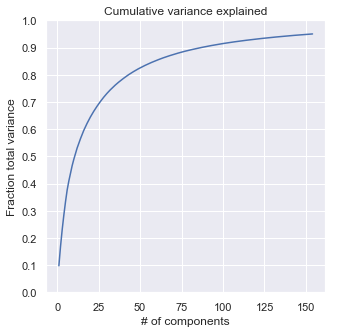

In [12]:
_ = ush.plot_cum_variance(pca_mnist)

variance_goal_pct = 95
features_for_goal = ush.num_components_for_cum_variance(pca_mnist, .01 * variance_goal_pct)
print("To capture {f:d}% of variance we need {d:d} synthetic features.".format(f=variance_goal_pct, d=features_for_goal))


So we need only about 20% of the original 784 features to capture 95% of the variance.

We can invert the PCA transformation to go from synthetic feature space back to original features.

That is, we can see what the digits look like when reconstructed from only 154 synthetic features.

First, let's look at the original:

(52500, 154)

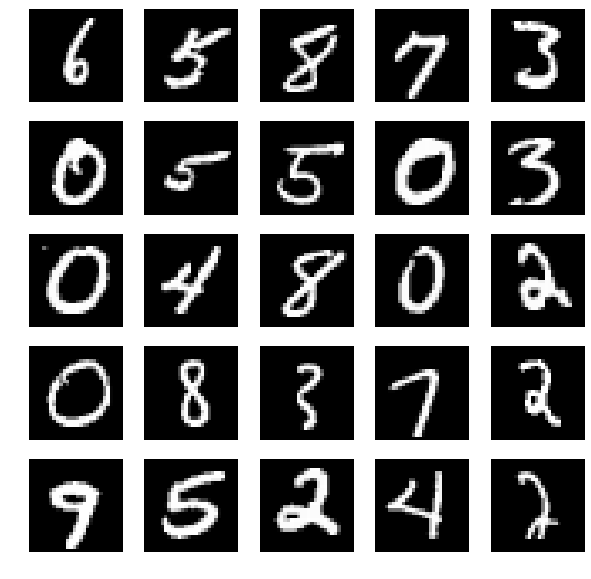

In [13]:

X_mnist_train_reduced = ush.transform(X_mnist_train, pca_mnist)
X_mnist_train_reduced.shape

# Show the original dataset
ush.mnh.visualize(X_mnist_train, y_mnist_train)

Next, the reconstructed

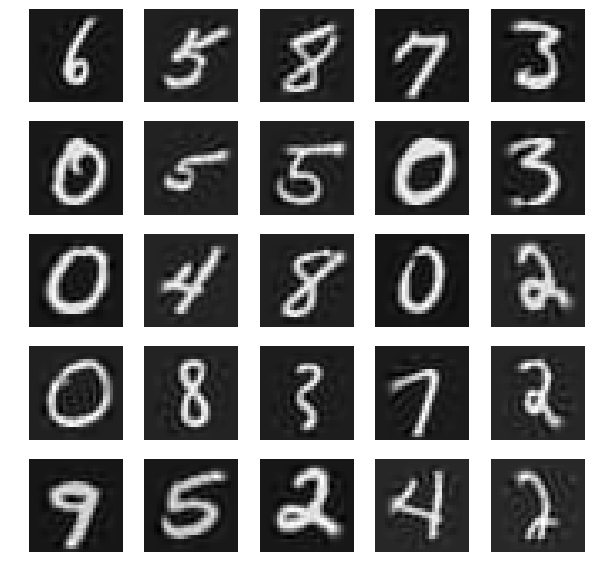

In [14]:
X_mnist_train_reconstruct = ush.inverse_transform(X_mnist_train_reduced, pca_mnist)
ush.mnh.visualize(X_mnist_train_reconstruct, y_mnist_train)

A little fuzzy, but pretty good.

Suppose we retained only 2 synthetic features.  

We would be able to plot each sample in
two dimensions using the transformed coordinates.

Although targets are not necessary for PCA, here we do have labels associated with the images.

Let's plot the samples and color them according to their target.

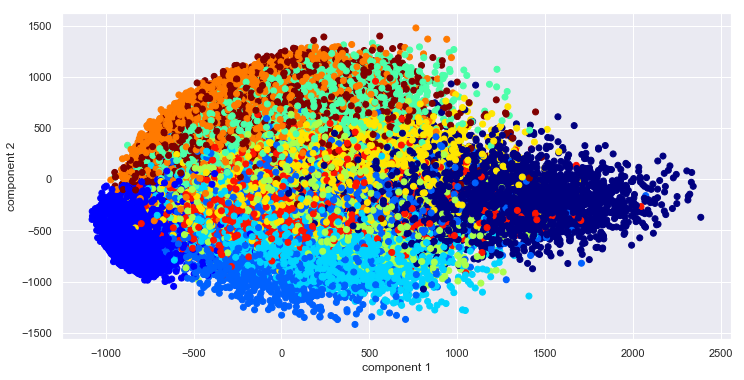

In [15]:
_ = ush.mnist_plot_2D(X_mnist_train_reduced, y_mnist_train.astype(int))

Each color is a different digit.

You can see that the clustering is far from perfect
- but also suprisingly good considering we're using only 2 out of 784 features

Let's see how much variance is captured by only the first two synthetic features.

In [16]:
cumvar_mnist = np.cumsum(pca_mnist.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_mnist[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * X_mnist_train.shape[1]))


Cumulative variance of 2 PC's is 16.91%, about 132.6 pixels


Is 17% good ?  You bet !

With 784 original features (pixels)
- if each feature had equal importance, it would explain $1/784 = .12\%$ of the variance.  

So the first synthetic feature captures the variance of 132 original features 
- (assuming all were of equal importance).


## A word on the inverse transformation

The transformation into synthetic features is
$$
\tilde\X = \X V
$$

If we multiply $\tilde\X$ by $V^T$
$$
    \tilde\X V^T = \X V V^T = \X
$$

So 
- $V$ transforms from original features to synthetic feature
- $V^T$ is the inverse transformation from synthetic features to original features


## Digits example

`sklearn` comes with a "digits" dataset that is like a low resolution version of MNIST: 8 by 8 pixels.

VanderPlas has a good [notebook](external/PythonDataScienceHandbook/notebooks/05.09-Principal-Component-Analysis.ipynb#PCA-as-dimensionality-reduction) illustrating PCA on this much smaller dataset.

We'll give a quick take on this, but I recommend the notebook.

Let's look at the digits data

In [17]:
from sklearn.datasets import load_digits
digits = load_digits()
digits.data.shape

(1797, 64)

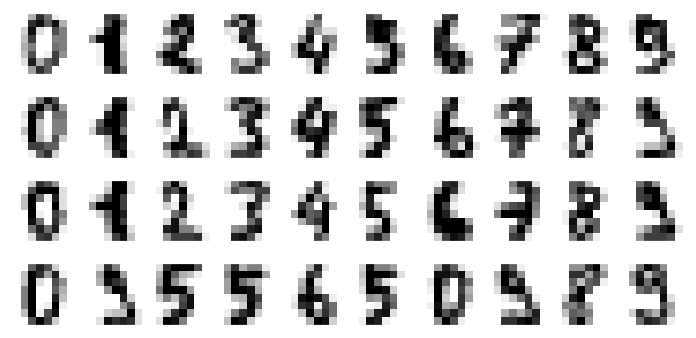

In [18]:
_ = vp.digits_plot(digits.data)

As you can see, each digit is represented by a grid of $8 \times 8$ pixels.

Let's reduce digits from 64 dimensions to only 2 and use this for clustering.

- Project to 2 synthetic features
- Use an inverse transformation to reconstruct back to original features

First, recall that if we retained all 64 sythetic features, we'd get a perfect reconstruction:

(1797, 64)
(1797, 64)


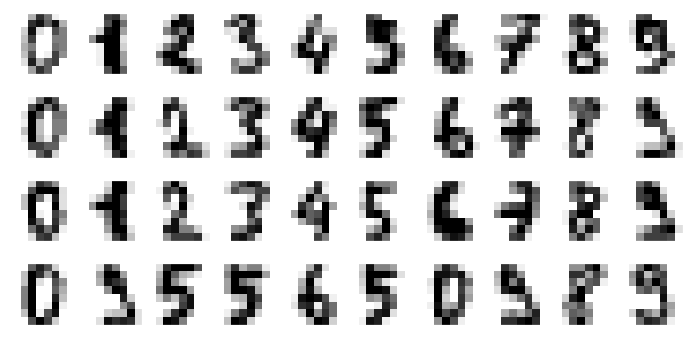

In [19]:
digits_pca, digits_projected, digits_reconstructed = vp.digits_reconstruction(digits.data)


Here's the reconstruction when retaining only 2 synthetic features.

(1797, 64)
(1797, 2)


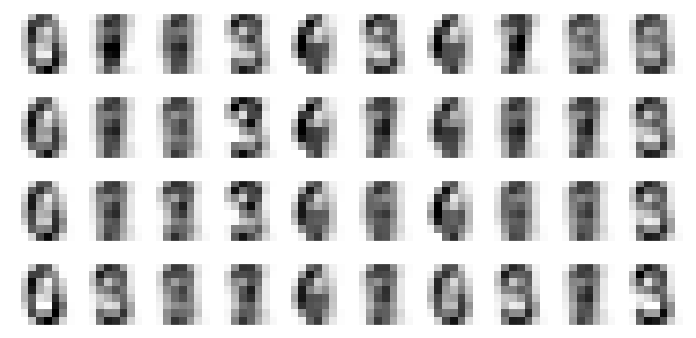

In [20]:
digits_pca2, digits_projected2, digits_reconstructed2 = vp.digits_reconstruction(digits.data, n_components=2)

Reconstruction is kind of fuzzy but the digits are recognizable. 

How much variance did we retain ?


In [21]:
cumvar_digits = np.cumsum(digits_pca2.explained_variance_ratio_)
first_comp =2
cumvar_first = cumvar_digits[first_comp-1]

print("Cumulative variance of {d:d} PC's is {p:.2f}%, about {n:.1f} pixels".format(
    d=first_comp, p=100 *cumvar_first, n=cumvar_first * digits.data.shape[1]))


Cumulative variance of 2 PC's is 28.51%, about 18.2 pixels


Two synthetic features capture almost 30% of the total variance.

More imporantly, let's visualize the clusters in synthetic feature (PC) space.

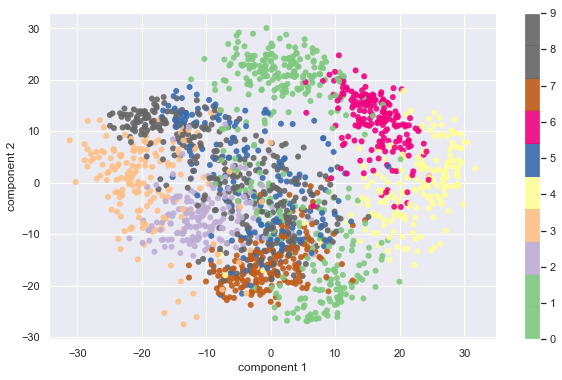

In [22]:
vp.digits_show_clustering(digits_projected2, digits.target)

Sometimes you an interpret the PC's by looking how they separate the clusters.

I admit: don't see it here though.

What would happen if we retained more than 2 synthetic features ?

Cumulative variance of 2 PCs is 0.285


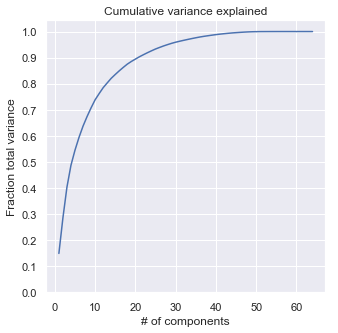

In [23]:
_ = vp.plot_cum_variance(digits_pca)
cumsum = np.cumsum(digits_pca.explained_variance_ratio_)
print("Cumulative variance of {nc:d} PCs is {cv:0.3f}".format(nc=2, cv=cumsum[2-1]) )

# PCA in Finance

## PCA of yield curve

[Litterman Scheinkman](https://www.math.nyu.edu/faculty/avellane/Litterman1991.pdf)

This is one of the most important papers (my opinion) in quantitative Fixed Income.

It allows us to hedge a large portfolio of bonds with a handful of instruments.


Before we show the result: why is this an important advance in Finance ?

- Imagine we had a large portfolio of bonds with many maturites.

- A common goal in Fixed Income Finance is to *immunize* (hedge) a portfolio to changes in the Yield Curve.

- A simple way to construct the hedge is to
    - find the sensivitity of each bond in the portfolio to the $n = 14 $ maturities
    - sum (over bonds in the portfolio) the individual bond sensitivities
    - minus 1 times resulting portfolio sensitivity is hedge that minimizes the portfolio's exposure to Yield Curve changes


But there are transaction costs (and complexity) with $n = 14$ bonds in the hedge portfolio.

Can we do nearly as well with $n' < n$ hedge bonds ?

That's exactly what PCA is designed for: dimensionality reduction.
- in this case, reducing the number of hedge bonds
- with minimal impact on immunization goal

Let's get the history of Yield Curves and look at first few samples.

In [24]:
ych = unsupervised_helper.YieldCurve_PCA()

# Get the yield curve data
data_yc = ych.create_data()
data_yc.head()

,1M,2M,3M,6M,1J,2J,3J,4J,5J,6J,7J,8J,9J,10J
1992-02-29,0.0961,0.09610,0.0961,0.0958,0.0898,0.0864,0.0849,0.0837,0.0826,0.0817,0.0810,0.0806,0.0803,0.0804
1992-03-31,0.0970,0.09700,0.0970,0.0969,0.0912,0.0889,0.0877,0.0864,0.0852,0.0841,0.0833,0.0827,0.0823,0.0823
1992-04-30,0.0975,0.09750,0.0975,0.0975,0.0920,0.0892,0.0877,0.0862,0.0848,0.0837,0.0828,0.0822,0.0817,0.0816
1992-05-31,0.0978,0.09785,0.0979,0.0979,0.0920,0.0889,0.0874,0.0860,0.0847,0.0836,0.0828,0.0821,0.0817,0.0815
1992-06-30,0.0974,0.09745,0.0975,0.0975,0.0931,0.0904,0.0889,0.0874,0.0860,0.0848,0.0839,0.0832,0.0827,0.0825


In [25]:
data_yc.shape

(287, 14)

Each example (row) has 14 features: the yields for 14 maturity points on a given date.

Let's plot the history of yield curves

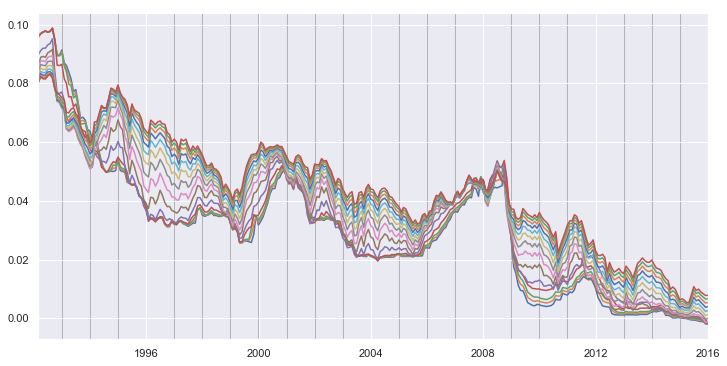

In [26]:
ych.plot_YC(data_yc)

Let's perform PCA on the **changes** in Yield Curve
- Just like in Supervised Learning, we sometimes need to transform the data before fitting a model
- The features we feed to PCA are *yield changes* rather than yields

So $n=14$ maturities, for $m$ samples (many years of daily data)


How many bonds (i.e, what is the $n'$) is "good enough" ?

The plot of cumulative variance explained, versus $n'$ will give us an answer.

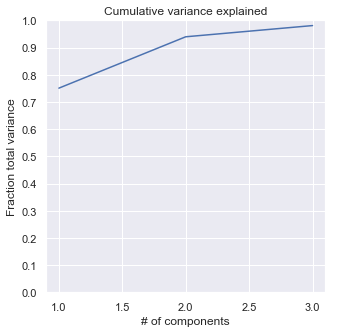

In [27]:
pca_yc, df_pca_yc = ych.doPCA(data_yc, doDiff=True)
_ = ych.plot_cum_variance(pca_yc)

Wow ! 

Only $n'=3$ synthetic features capture almost all the variance of the original $n =14$ features !

It gets even better !

By examining the composition of the synthetic features, we can *interpret* what they are 


Let's examine the effect of a 1 standard deviation move in each synthetic feature on
original features.  

We arrange the original features by maturity on the horizontal axis
and plot the effect on the vertical.

The choice to arrange the horizontal axis by maturity is *very deliberate*, as we will see.

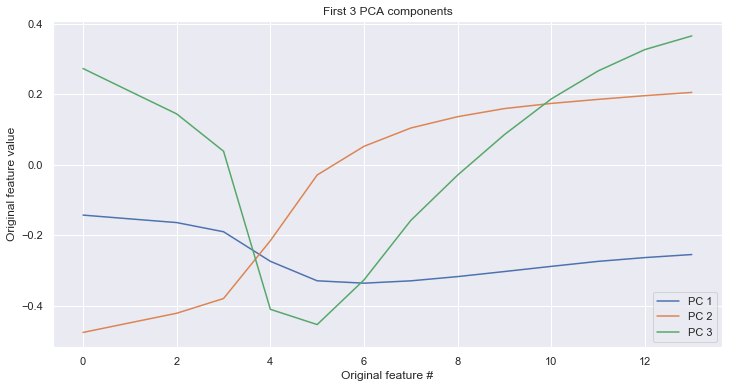

In [28]:
ych.plot_components(pca_yc)

This is a very typical pattern in Finance:
- the first synthetic feature affects all original features with roughly equal effect
- higher synthetic features often express a *dichotomy*
    - positive effect on some original features
    - negative effect on other original features
    

In our case the original features are yield changes.

A unit standard deviation value of synthetic  feature $j$ (PCj) 
- $(j=1)$: affects all original features (yield change)  roughly equally
    - corresponds to a parallel shift in the Yield Curve
- $(j=2)$: shows a dichotomy (of yield changes) between near and far maturities
    - corresponds to the slope of the Yield Curve changing
- $(j=3)$: shows a dichotomy of yield changes of mid maturies versus extreme maturities
    - corresponds to a twist in the Yield Curve about the 5 year maturity


**Recall**

The synthetic features are standardized, hence 1 unit is one standard deviation.

The $\Sigma$ matrix re-scales from standard deviation to original feature space.

- So can't compare the levels on the vertical axis between synthetic features.

    - Since $\sigma_1 > \sigma_2$ 
    - the absolute effect of synthetic feature 1 is greater than that of
synthetic feature 2 
    - for a 1 standard deviation move in each.

We started with a complicated sample (Yield Curve with $n=14$ features)
- can almost completely explain
(changes in the Yield Curve) with 3 intuitive market changes
    - Parallel Shift up/down of all maturities
    - Long end versus short end changes (slope)
    - Twist at intermediate maturity

That's interesting from a Machine Learning perspective but important for Finance:
- It shows show to construct efficient Hedge Portfolios.

Suppose we have a Target Portfolio consisting of long positions in many bonds, with many maturities.

Our goal is to construct another portfolio (the Hedge Portfolio)
- consisting of a small number of bonds
- with the *same* sensitivity to Yield Curve changes as the Target Portfolio 

By combining a long position in the Target Portfolio with a short position in the Hedge Portfolio
- the resulting Net Portfolio is immunized (hedged) to changes in the Yield Curve

If we can re-express our Target Portfolio in terms of synthetic features
- We can construct the Hedging Portfolio as one consisting only of 3 synthetic bonds
- In quantities that mimic the sensitivity of the Target Portfolio to the first 3 PCs.
    - since the PCs are *independent*, this is easy
    - normally:  you would need to solve
         -  a system of 3 equations in 3 unknowns (size of position in each synthetic bond)

The catch is that each synthetic bond (feature) is a linear combination of $n=14$ real bonds.

So we would need $n$ real bonds to create each synthetic.

One way to deal with this is to project the synthetic features onto $n'' < 14$ real bonds.

So we come up with "approximate" versions of the synthetic features themselves.

The interpretation of Yield Curve changes guides us into a simpler hedge
- Hedge the parallel shift with the 10 year Treasury (most liquid bond in the US)
    - works because all yield changes roughly the same for first PC
- Hedge the slope with a long/short portfolio of 2 year/30 year (or 10 year) bonds
    - also liquid instruments, that are "close enough" to PC2
- Hedge the twist with a butterfly of long 2 year/10 year, short 5 year

So our Hedging Portfolio will consist of just a handful of very liquid bonds
- as opposed to $n$ bonds, many of which may be illiquid


The primary way of hedging Fixed Income portfolios prior to this was by
*duration* hedging
- assuming that yields across all maturities moved the same amount
- using a single liquid bond as the Hedge Portfolio

The PCA verified that the simple, intuitive hedge was actually the most important hedge to make !

### Finance details

This section has little to do with Machine Learning but quite a bit to do with Fixed Income Finance.

- We have captured changes in *yield* of a bond
- To hedge *price* changes (our goal) we still need to translate a yield change to a price change

- For bond $b$ with price $P_b$ and yield $y_b$ 
    - we need $\frac{\partial P_b}{\partial y_b}$
        - the change in Price of bond $b$ per unit change in its yield
    - this is known as the bond's *duration*
    - if we hold $\#_b$ units of bond $b$ in a Portfolio
        - the bond's contribution to portfolio price change is $\#_b$ times the above sensitivity
    - sometimes more convenient to compute the *percent price* change per unit yield change
        - size of the hedge now in *number of dollars* rather than *number of bonds*
 

## PCA of the SP 500

The same analysis that we did for the Bond Universe works for other instruments.

Consider a universe of all stocks in a particular stock universe.

We can perform PCA on the returns (percent changes) of each stock
- discover the common factors affecting all stocks in the universe.
- $n = 500$ features, for each example (one day return)

We don't have time to do it here, but the first components of many universes tends to be
- a first component that has roughly equal impact
    - PC1 is almost an equally weighted portfolio of all stocks
- higher components expressing dichotomies
    - cyclical stocks versus non-cyclical
    - large cap versus small cap
    - industry versus other industry
    

## Interpretting the PC's

The key in our interpetation of the PCs for the Yield Curve
- choice of
ordering our original features by sorted maturity.

Had we chosen some other arrangement of the horizontal axis, we may not have seen the pattern.

So how do we find the "right" pattern ?

- Assign each original feature a set of attributes
    - bonds: maturity
    - stocks: industry, market capitization
- Propose a "theory" about how the value of an original feature will respond to a level of the PCj
    - The theory should relate the attribute of an original feature to the value of feature
- As a horizontal axis: sort by the attribute proposed by your theory
    - Stocks:
        - $(j=1)$: arbitrary arrangement works, since all stocks repsonds equally
        - $(j>1)$: cluster stocks by attribute
            - sort by market capitilization
            - group by industry: first all Industrials, then all Techs, etc.

Let $\hat{u}$ be the $1 \times n$ vector of all $0$'s except for a $1$ at position $i$
$$
\begin{array}{lll}
\hat{u}_i & = & 1 \\
\hat{u}_j & = & 0, \hspace{3ex} j \ne i
\end{array}
$$

Then
$$
s = \hat{u} I V^T
$$
is a $1 \times n$ vector whose elements are the effect of a one standard deviation shock in synthetic factor $i$ on each original feature.
$$
s_j = \text{change in } X_j \text{ for a 1 standard deviation change in } \tilde{X_i}
$$

$$
s' = \hat{u} \Sigma V^T
$$
is a $1 \times n$ vector that is scaled by the actual standard deviation of $\tilde{X}_i$ since the absolute size of a 1 standard deviation change in $\tilde{X}_i$ is $\sigma_i$.

That is:
row $i$ of $V^T$ is the effect on each original feature of a one standard deviation shock in synthetic feature $\tilde{X}_i$.

# Clustering

Arrange examples into groups, based on similarity of features.

We will briefly review some methods.


## PCA: an enabler for clustering

Plotting examples in synthetic feature space
- clusters often become apparant to the human eye.

This however is not clustering: we need an algorithm to achieve what the human intuits.

Principal Component decomposition is complementary to Clustering
- dimension reduction of PCA makes it easier to find clusters



## K-means clustering
## Hierarchical clustering

# Recommender Systems: Pseudo SVD

There is another interesting use of Matrix Factorization that we will briefly review.

It will show both a case study and interesting extension of SVD.

## Netflix Prize competition
- Predict user ratings for movies
- Dataset
    - Ratings assigned by users to movies: 1 to 5 stars
    - 480K users, 18K movies; 100MM ratings total
- $1MM prize
- awarded to team that beat Netflix existing prediction system by at least 10 percentage points

## User preference matrix

We will try to use same language as PCA (examples, features, synthetic features)
- but map them to Netflix terms
    - Examples: Viewers
    - Features: Movies ("items")

Matrix $\X$: user rating of movies

$X_j^{(i)}$ is $i^{\text{th}}$ user's rating of movie $j$

$X$ is huge: $m *n$
- $m = .5$ million viewers
- $n = 18,000$ items (movies).

About 9 billion entries for a full matrix !


## Idea: Linking Viewer to Movies via concepts

- Come up with your own "concepts" (synthetic features)
    - concept = attribute of a movie
        - map user preference to concept
        - map movie style to concept
        - supply and demand: 
            - user demands concept, movie provides concept

### Human defined concepts
- style: action, adventure, comedy, sci-fi
- actor
- typical audience segment

- Create user profile $P$: maps user to concept
- Create item profile $Q$: maps movies (features, items) to concept
- $\X = P Q^T$

One advantage of the $\X = P Q^T$ approach is a big space reduction.

With $k \le n$ concepts:
- $\X$ is $m \times n$
- $P$ is $m \times k$
- $Q$ is $n \times k$

So idea is to factor $X$ and discover $k \le n$ synthetic features (concepts, "latent factors)


- $\X = P Q^T$
    - fit the model on training examples, i.e., perform decomposition
- Given a new user (test example), predict rating for an unseen movie:
    - Get a partial vector of user's ratings (defined for movies seen by user)
        - original features
    - Project onto concepts (synthetic features): 
    - Inverse transform to get back complete vector in original feature space



### SVD to discover concept

Why let a human guess what ML can discover ?  

Use SVD to discover the $k$ "best" synthetic features, rather than leaving it to a person.

Factor $\X$ by SVD !

$\X = U \Sigma * V^T$

Let $P = U \Sigma, Q = V$

Anyone spot the problem(s) ?

- First: a matrix with 9 billion entries is a handful !

- As you can imagine, any single user views only a fraction of the $m$ movies
    - $\X$ is very sparse 
    - Of the $9$ billion potential entries in the full matrix $\X$, we only have $100$ million defined.

How can we perform SVD on matrix with missing values ?

- Missing value imputation
    - not attractive: most values are missing
- Pseudo SVD

**The ML mantra**
- find a (cool ?) cost function that describes a solution to your problem
- Use Gradient Descent to solve

## Pseudo SVD Cost function

The Froebenius Norm (used above) modified to exclude missing values

$$
Cost(\X',\X) = \sum\limits_{\substack{1 \le i \le m,\\ 1 \le j \le n \\ \X_j^{(i)} \text{defined}}} { \left(  \X_j^{(i)} - {\X'}_j^{(i)} \right)^2}
$$

where $\X' = P Q^T$

Interpret as Reconstruction Error

### Pseudo SVD algorithm

- Define $\X' = P Q^T$

- Take analytic derivatives of $Cost(X', X)$ with respect to
    - $P_j^{(i)}$ for $1 \le i \le m, 1 \le j \le k$
    - $Q_j^{(i)}$ for $1 \le i \le m, 1 \le j \le k$

- Initialize elements of $P, Q$ randomly.

- Use Gradient Descent to solve for optimal entries of $P, Q$.
    - find entries of $P, Q$ such that product matches non-empty part of $\X$

**Note**
- No guarantee that the $P, Q$ obtained are
    - orthonormal, etc. (which SVD would give you)

But SVD won't work for $\X$ with missing values.

### Filling in missing values

Once you have $P, Q$

- to predict a missing rating for user $i$ movie $j$:

$$\hat{r}_{j,i} =  q^\ip \cdot p_j^T$$ 
- $q^\ip$ is row $i$ of $Q$
- $p_j$ is column $j$ of $P^T$

### Some intuition

The rating vector of a user may have missing entries.

But we can still project to synthetic feature space based on the non-empty entries.

The projection winds up in a "neighborhood" of concepts.

Inverse transformation 
- gets us to a completely non-empty rating vector that is a resident of this neighborhood.

**Example**

User rates 
- Sci-Fi movies A and B very highly 
- Does not rate Sci-Fi movie C.

Since A,B, C express same concept (Sci-Fi) they will be close in synthetic feature space.

Hence, the implied rating of User for movie C will be close to what other users rate C.

In [29]:
print("Done")

Done
